In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import env
import math
import numpy as np
import pickle
import string
from bm.utils.dataset import *
from bm.utils.plot_utils import *
from rbm_utils.stutils import *
from rbm_utils.fimdiag import * # functions to compute the diagonal of the FIM for RBMs
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.gridspec as gridspec
from matplotlib.ticker import ScalarFormatter
from pruning.MNIST_Baselines import *

np.random.seed(42)

GATHER = [
    '#eb7a59', # "Rust"
    '#eea300', # "Ochre"
    '#5aa0df', # "Azure"
    '#00bac9', # "Turquoise"
    '#CC79A7', # "Violet"
    '#F0E442', # "Yellow"
    '#44525c', # "Black"
    '#f1f0e9'] # "White"
RUST,OCHRE,AZURE,TURQUOISE,VIOLET,YELLOW,BLACK, WHITE = GATHER
fs=16
plt.rcParams.update({'font.size': fs})

## Load results
### Load or create evaluation results of initial model

In [10]:
n_iter = 10
n_checkpoint = 2
perc = 10

res_path = os.path.join('..', 'models', 'MNIST')
initial_path = os.path.join(res_path,'initial')
assert os.path.exists(initial_path), "Model does not exist yet. Train initial DBM first by running pruning/MNIST_Baselines.py - requires GPU"

dbm = get_initial_DBM(initial_path) # loads initial DBM. 
params = dbm.get_params()
n_vis = params['n_visible_']
nh1 = initial_units_l1 = params['n_hiddens_'][0]
nh2 = initial_units_l2 = params['n_hiddens_'][1]
rec_fields = dbm.get_tf_params(scope='masks')['rf_mask']
initial_n_weights_l1 = len(rec_fields.flatten()[rec_fields.flatten()==1])
initial_n_weights_l2 = int(nh1 * nh2)

try: 
    initial_probs_win_digits = np.load(os.path.join(initial_path,'ProbsWinDig_Initial_Samples.npy'))[1,:]
    initial_count_digits = np.load(os.path.join(initial_path,'ProbsWinDig_Initial_Samples.npy'))[2,:]
    initial_logreg = np.load(os.path.join(initial_path, 'Accuracy_hidden_layer_reps.npy'))
except IOError: 
    evaluate_initial_DBM(dbm, initial_path)
    initial_probs_win_digits = np.load(os.path.join(initial_path,'ProbsWinDig_Initial_Samples.npy'))[1,:]
    initial_count_digits = np.load(os.path.join(initial_path,'ProbsWinDig_Initial_Samples.npy'))[2,:]
    initial_logreg = np.load(os.path.join(initial_path, 'Accuracy_hidden_layer_reps.npy'))
del dbm


Loading RBM #1 ...


No pruning, array of ones is initialized

Loading RBM #2 ...


No pruning, array of ones is initialized

Loading DBM ...


INFO:tensorflow:Restoring parameters from ../models/MNIST/initial/MNIST_DBM_Layer1/model
INFO:tensorflow:Restoring parameters from ../models/MNIST/initial/MNIST_DBM_Layer2/model
INFO:tensorflow:Restoring parameters from ../models/MNIST/initial/MNIST_DBM_Layer1/model
INFO:tensorflow:Restoring parameters from ../models/MNIST/initial/MNIST_DBM_Layer2/model
INFO:tensorflow:Restoring parameters from ../models/MNIST/initial/MNIST_InitialDBM/model


### Load or create MNIST baselines

In [15]:
if not os.path.exists(os.path.join(res_path, "logreg_MNIST.pkl")):
    _ = create_baseline_classifier(res_path)
    
test_probs_digits = np.load(os.path.join(res_path,'ProbsWinDig_TestDigits.npy'))[1,:]
test_count_digits = np.load(os.path.join(res_path,'ProbsWinDig_TestDigits.npy'))[2,:]
mean_test_prob = np.mean(test_probs_digits)

random_probs_digits = np.load(os.path.join(res_path,'ProbsWinDig_Random.npy'))[1,:]
random_count_digits = np.load(os.path.join(res_path,'ProbsWinDig_Random.npy'))[2,:]
mean_random_prob = np.mean(random_probs_digits)

acc_rawdigits_logreg = np.load(os.path.join(res_path, 'Accuracy_TestDigits.npy'))

### Load results of pruned models

In [18]:
exp_labels=['Variance FI', 'Heuristic FI', r'|w|', 'Random', 'Anti-FI']
exp_names = [f'varianceFI_{perc}perc_{n_iter}sessions', 
             f'heuristicFI_{perc}perc_{n_iter}sessions', 
             f'w_{perc}perc_{n_iter}sessions', 
             f'random_{perc}perc_{n_iter}sessions', 
             f'antiFI_{perc}perc_{n_iter}sessions']
exp_colors = GATHER
for i, exp in enumerate(exp_names): 
    assert os.path.exists(os.path.join(res_path, exp)), f"Pruning experiment does not exist yet. Run {exp_labels[i]} pruning script"

### Load encoding performance results of pruned models

In [24]:
acc_logreg = []
n_act_weights_l1 = []
n_act_weights_l2 = []
n_hid_units_L1 = []
n_hid_units_L2 = []

for exp in range(len(exp_names)):
    temp_link = res_path+'/{}/res'.format(exp_names[exp])

    acc_logreg.append(np.load(os.path.join(temp_link,'AccLogReg.npy')).flatten())
    n_act_weights_l1.append(np.load(os.path.join(temp_link, 'n_active_weights_L1.npy')).flatten())
    n_act_weights_l2.append(np.load(os.path.join(temp_link, 'n_active_weights_L2.npy')).flatten())
    n_hid_units_L1.append(np.load(os.path.join(temp_link, 'n_hid_units_L1.npy')).flatten())
    n_hid_units_L2.append(np.load(os.path.join(temp_link, 'n_hid_units_L2.npy')).flatten())

    # add the initial performance
    acc_logreg[exp] = np.insert(acc_logreg[exp], 0, initial_logreg)
    n_hid_units_L1[exp] = np.insert(n_hid_units_L1[exp],0, initial_units_l1)
    n_hid_units_L2[exp] = np.insert(n_hid_units_L2[exp], 0, initial_units_l2)
    n_act_weights_l1[exp] = np.insert(n_act_weights_l1[exp], 0, initial_n_weights_l1)
    n_act_weights_l2[exp] = np.insert(n_act_weights_l2[exp], 0, initial_n_weights_l2)

# convert lists to arrays
acc_logreg = np.asarray(acc_logreg)[:,:n_iter*2+1]
n_act_weights_l1 = np.asarray(n_act_weights_l1)[:,:n_iter*2+1]
n_act_weights_l2 = np.asarray(n_act_weights_l2)[:,:n_iter*2+1]
n_hid_units_L1 = np.asarray(n_hid_units_L1)[:,:n_iter*2+1]
n_hid_units_L2 = np.asarray(n_hid_units_L2)[:,:n_iter*2+1]

### Load generative performance results of pruned models

In [25]:
diversity_digits_all = [[]  for i in range(len(exp_names))]
mean_prob_all = [[]  for i in range(len(exp_names))]
min_prob_all = [[]  for i in range(len(exp_names))]
max_prob_all = [[]  for i in range(len(exp_names))]
entropy_all = [[] for i in range(len(exp_names))]
probs_win_digits_all = [[] for i in range(len(exp_names))]
count_digits_all = [[] for i in range(len(exp_names))]
which_digit_all = [[] for i in range(len(exp_names))]

for exp in range(len(exp_names)):
    temp_link = res_path+'/{}/res'.format(exp_names[exp])

    probs_win_digits = []
    count_digits = []

    probs_win_digits.append(initial_probs_win_digits)
    count_digits.append(initial_count_digits)
    entropy_all[exp].append(entropy(initial_count_digits))
    count_digits_all[exp].append(initial_count_digits)
    which_digit_all[exp].append(range(10))
    probs_win_digits_all[exp].append(initial_probs_win_digits)
    
    for sess in np.arange(1,n_iter+1):
        for checkpoint in np.arange(1,n_checkpoint+1):
            which_digit_all[exp].append(np.load(os.path.join(temp_link, 'ProbsWinDig_sess{}_checkpoint{}.npy'.format(sess,checkpoint)))[0,:])
            temp = np.load(os.path.join(temp_link, 'ProbsWinDig_sess{}_checkpoint{}.npy'.format(sess,checkpoint)))[1,:]
            count = np.load(os.path.join(temp_link, 'ProbsWinDig_sess{}_checkpoint{}.npy'.format(sess,checkpoint)))[2,:]
            entropy_all[exp].append(entropy(count))
            probs_win_digits.append(temp)
            count_digits.append(count)
            count_digits_all[exp].append(count)
            probs_win_digits_all[exp].append(temp)

    probs_win_digits = np.asarray(probs_win_digits)
    count_digits = np.asarray(count_digits)

    mean_prob = np.zeros(len(probs_win_digits))
    max_prob = np.zeros(len(probs_win_digits))
    min_prob = np.zeros(len(probs_win_digits))

    for i in range(len(probs_win_digits)):
        mean_prob[i] = np.mean(probs_win_digits[i], axis=0)
        max_prob[i] = probs_win_digits[i].max()
        min_prob[i] = probs_win_digits[i].min()

    # we only saved these two times
    diversity_digits = np.zeros(len(count_digits))
    for i in range(len(count_digits)):
        if len(count_digits[i]) < 10: # if one category has a zero count
            min_counts = 0
        else:
            min_counts = count_digits[i].min()
        max_counts = count_digits[i].max()
        diversity_digits[i] = min_counts/max_counts

    diversity_digits_all[exp].append(diversity_digits)
    mean_prob_all[exp].append(mean_prob)
    min_prob_all[exp].append(min_prob)
    max_prob_all[exp].append(max_prob)

entropy_all = np.asarray(entropy_all) 
diversity_digits_all = np.asarray(diversity_digits_all)[:,0,:]
mean_prob_all = np.asarray(mean_prob_all)[:,0,:]
min_prob_all = np.asarray(min_prob_all)[:,0,:]
max_prob_all = np.asarray(max_prob_all)[:,0,:]

## Figure: Final visible layers
### Retrieve final visible layers

In [26]:
indices_unconnected_v = []
for exp in range(len(exp_names)):
    temp_path = os.path.join(res_path, f'{exp_names[exp]}', 'res')
    if not os.path.exists(os.path.join(temp_path, 'final_indices_of_lost_visibles.npy')):
        model_path = os.path.join(os.path.join(res_path, f'{exp_names[exp]}', f'MNIST_PrunedDBM_both_Sess{n_iter}'))
        dbm = DBM.load_model(model_path+'/')
        prune_mask = dbm.get_tf_params(scope='masks')['prune_mask']
        out_synapses = np.sum(mask, axis=1) # sum of outgoing synapses from the visible layer
        current_unconnected_v = sum(out_synapses==0)
        ind = np.argwhere(out_synapses == 0)
        if len(ind)==0:
            indices_unconnected_v.append(None)
        else:
            indices_unconnected_v.append(ind)
        np.save(os.path.join(temp_path, 'final_indices_of_lost_visibles.npy'), ind)
        del dbm
    else:
        indices_unconnected_v.append(np.load(os.path.join(temp_path, 'final_indices_of_lost_visibles.npy')))

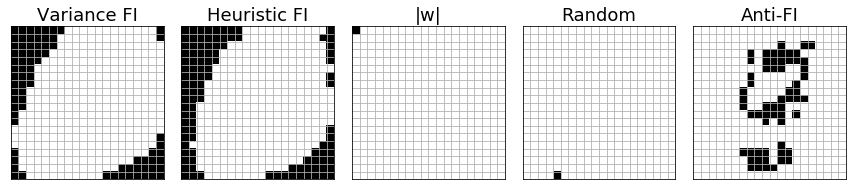

In [27]:
fig = plt.figure(figsize=(12,6))#constrained_layout=True

gs = gridspec.GridSpec(1, len(exp_names))
for i in range(len(exp_names)):
    ax = fig.add_subplot(gs[0, i])
    visible = np.ones(400)
    visible[indices_unconnected_v[i]]=0
    im = ax.imshow(visible.reshape(20,20), cmap=plt.cm.binary_r)
    ax.set_xticks(np.arange(0.5,20), [])
    ax.set_yticks(np.arange(0.5,20), [])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    title= exp_labels[i]
    ax.set_title(title, fontsize=fs+2)
    ax.grid()

plt.tight_layout()
plt.show()

## Figure: Exemplary visible samples
### Retrieve final visible samples

In [28]:
samples_v = []
n_samples = 25
for exp in range(len(exp_names)):
    temp_path = os.path.join(res_path, f'{exp_names[exp]}', 'res')
    if not os.path.exists(os.path.join(temp_path, f'final_visible_samples_n{n_samples}.npy')):
        model_path = os.path.join(os.path.join(res_path, f'{exp_names[exp]}', f'MNIST_PrunedDBM_both_Sess{n_iter}'))
        dbm = DBM.load_model(model_path+'/')
        sample = dbm.sample_gibbs(n_gibbs_steps=10, save_model=True, n_runs=np.max([n_samples, 10000]))
        sample_v = sample[:,:n_vis] # extract visible samples
        random_indices = random.sample(range(sample_v.shape[0]), n_samples) 
        random_sample_v = sample_v[random_indices, :].astype('bool') # randomly select some visible samples
        samples_v.append(random_sample_v)
        np.save(os.path.join(temp_path, f'final_visible_samples_n{n_samples}.npy'), random_sample_v)
        del dbm
    else:
        samples_v.append(np.load(os.path.join(temp_path, f'final_visible_samples_n{n_samples}.npy')))

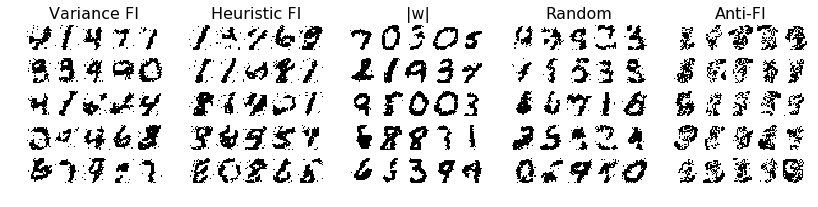

In [29]:
fig = plt.figure(figsize=(14, 3))
outer = gridspec.GridSpec(1, len(exp_names))

for j in range(len(exp_names)):
    inner = gridspec.GridSpecFromSubplotSpec(int(math.sqrt(n_samples)), int(math.sqrt(n_samples)),
                    subplot_spec=outer[j], wspace=0.1, hspace=0.1)
    for i in range(int(math.sqrt(n_samples))*int(math.sqrt(n_samples))):
        if i < len(samples_v[j].T):
            img = samples_v[j][i].reshape((int(math.sqrt(n_vis)),int(math.sqrt(n_vis))))
            ax = plt.Subplot(fig, inner[i]) 
            for d in ('bottom', 'top', 'left', 'right'):
                ax.spines[d].set_linewidth(1.)
            if i == 2:
                ax.set_title(exp_labels[j], fontsize=16)
            ax.axis('off')
            ax.imshow(img, cmap =plt.cm.binary)
            fig.add_subplot(ax)

## Figure: Encoding performance

In [30]:
PostPrune = False # whether to show performance immediately after pruning
show_every = 2# set to 1 if you want to display pruned & retrained in the same plot

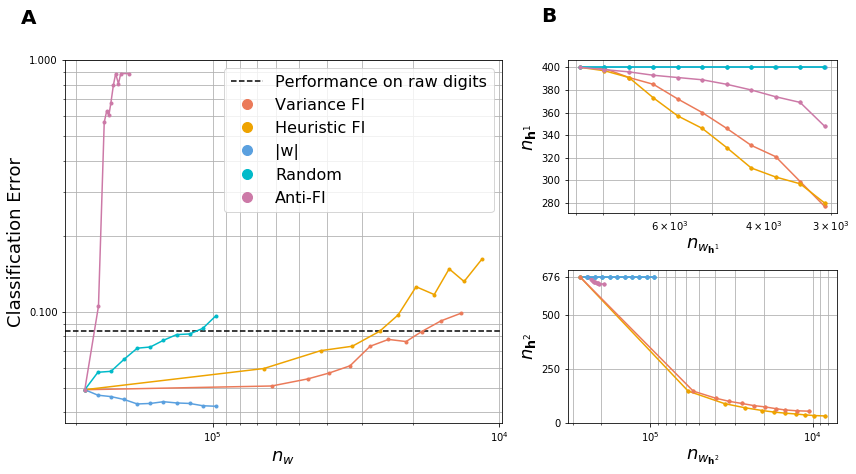

In [31]:
fig = plt.figure(figsize=(12,6))#constrained_layout=True

gs = gridspec.GridSpec(2, len(exp_names))
ax1 = fig.add_subplot(gs[0:2, 0:3])

ax1.axhline(1-acc_rawdigits_logreg, color='black', linestyle='--', label='Performance on raw digits')
ax1.text(-0.1, 1.1, string.ascii_uppercase[0], transform=ax1.transAxes,
            size=20, weight='bold')
for exp in range(len(exp_names)):
    ax1.plot(n_act_weights_l2[exp][0::show_every]+n_act_weights_l1[exp][0::show_every], 1-acc_logreg[exp][0::show_every], c=exp_colors[exp],marker=".")
    if PostPrune:
        ax1.plot(n_act_weights_l2[exp][1::show_every]+n_act_weights_l1[exp][1::show_every], 1-acc_logreg[exp][1::show_every], c=exp_colors[exp],marker="v", linestyle='None')

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.yaxis.set_major_formatter(ScalarFormatter())
ax1.set_ylim(None,1)
ax1.set_xlabel(r'$n_w$', fontsize=fs+2)
ax1.invert_xaxis()
ax1.set_ylabel('Classification Error', fontsize=fs+2)

for exp in range(len(exp_names)):
    ax1.plot([-5], [0], marker='o', markersize=10, color=exp_colors[exp], label=exp_labels[exp], linestyle='None')
ax1.legend(loc='best', fontsize=fs)
ax1.grid(True, which='both')

ax2 = fig.add_subplot(gs[0, 3:])
ax2.text(-0.1, 1.25, string.ascii_uppercase[1], transform=ax2.transAxes,
            size=20, weight='bold')
for exp in range(len(exp_names)):
    ax2.plot(n_act_weights_l1[exp], n_hid_units_L1[exp], c=exp_colors[exp], marker=".")
ax2.invert_xaxis()
ax2.set_xscale('log')
ax2.set_xlabel(r'$n_{w_{\mathbf{h}^1}}$', fontsize=fs+2)
ax2.set_ylabel(r'$n_{\mathbf{h}^1}$', fontsize=fs+2)
ax2.grid(True, which='both')

ax3 = fig.add_subplot(gs[1, 3:])

for exp in reversed(range(len(exp_names))):
    ax3.plot(n_act_weights_l2[exp], n_hid_units_L2[exp], c=exp_colors[exp], marker=".")

ax3.invert_xaxis()
ax3.set_xscale('log')
ax3.set_xlabel(r'$n_{w_{\mathbf{h}^2}}$', fontsize=fs+2)
ax3.set_ylabel(r'$n_{\mathbf{h}^2}$', fontsize=fs+2)
ax3.grid(True, which='both')
ax3.set_yticks([0,250,500,676])

plt.tight_layout()
plt.show()

## Figure: digit quality during pruning

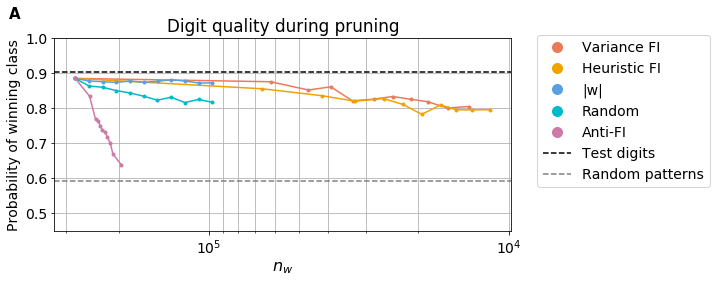

In [32]:
fig = plt.figure(figsize=(12,4))#constrained_layout=True
plt.rcParams.update({'font.size': 14})

gs = gridspec.GridSpec(2, 3)
ax1 = fig.add_subplot(gs[0:2, 0:2])

for exp in range(len(exp_names)):
    ax1.plot(n_act_weights_l2[exp][0::show_every]+n_act_weights_l1[exp][0::show_every], mean_prob_all[exp][0::show_every], c=exp_colors[exp], marker='.')
    if PostPrune:
        ax1.plot(n_act_weights_l2[exp][1::show_every]+n_act_weights_l1[exp][1::show_every], mean_prob_all[exp][1::show_every], c=exp_colors[exp], marker='v', linestyle='None')
for exp in range(len(exp_names)):
    ax1.plot([-5], [0], marker='o', markersize=10, color=exp_colors[exp], label=exp_labels[exp], linestyle='None')
ax1.set_xscale('log')
ax1.text(-0.1, 1.1, string.ascii_uppercase[0], transform=ax1.transAxes,
            size=15, weight='bold')
ax1.invert_xaxis()
ax1.set_title('Digit quality during pruning')
ax1.set_ylabel('Probability of winning class', fontsize=fs-2)
ax1.axhline(mean_test_prob, label='Test digits', color='black', linestyle='--')
ax1.axhline(mean_random_prob, label='Random patterns', color='grey', linestyle='--')
ax1.set_ylim(0.45,1.)
ax1.set_xlabel(r'$n_w$', fontsize=fs)
ax1.set_yticks(np.arange(0.5, 1.01, step=0.1))
ax1.grid(True, which='both')
ax1.legend(loc='upper right', fontsize=fs-2, bbox_to_anchor=(1.45, 1.05))

plt.tight_layout()
plt.show()

## Figure: digit diversity during pruning

In [34]:
which_digit_complete = np.zeros((len(exp_names), len(which_digit_all[0]), 10), dtype=int)
count_digit_complete = np.zeros((len(exp_names), len(which_digit_all[0]), 10), dtype=int)
probs_win_digits_complete = np.zeros((len(exp_names), len(which_digit_all[0]), 10), dtype=float)

for exp in range(len(exp_names)):
    for tp in range(len(count_digits_all[exp])):
        for d in range(10):
            which_digit_complete[exp, tp, d] = d

#augment the arrays with zeros for the classes that have zero counts:
for exp in range(len(exp_names)):
    for tp in range(len(count_digits_all[exp])):
        for index, number in enumerate(which_digit_all[exp][tp]):
            count_digit_complete[exp,tp,int(number)] = int(count_digits_all[exp][tp][index])
            probs_win_digits_complete[exp,tp,int(number)] = probs_win_digits_all[exp][tp][index]

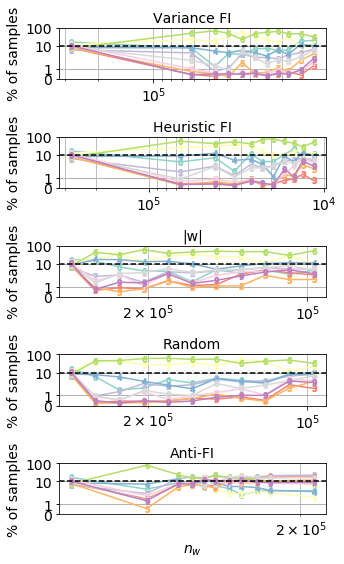

In [35]:
fig = plt.figure(figsize=(5,8))#constrained_layout=True
gs = gridspec.GridSpec(len(exp_names), 1)
for exp in range(len(exp_names)):
    ax = fig.add_subplot(gs[exp, 0])
    ax.set_ylabel('% of samples', fontsize=fs-2)
    for number in range(10):
        ax.plot(n_act_weights_l2[exp][0::show_every]+n_act_weights_l1[exp][0::show_every], count_digit_complete[exp,0::show_every,number].astype(float)/600, marker='${}$'.format(int(number)), c=plt.cm.Set3.colors[number])
        if PostPrune:
            ax.plot(n_act_weights_l2[exp][1::show_every]+n_act_weights_l1[exp][1::show_every], count_digit_complete[exp,1::show_every,number].astype(float)/600, marker='${}$'.format(int(number)), linestyle='None', c=plt.cm.Set3.colors[number])
    ax.axhline(10.0, color='black', linestyle='--')
    ax.invert_xaxis()
    ax.grid(which='both')
    ax.set_xscale('log')
    ax.set_yscale('symlog')
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.set_ylim(0,100)
    ax.set_title(exp_labels[exp], fontsize=fs-2)
    if exp==len(exp_names)-1:
        ax.set_xlabel(r'$n_w$', fontsize=fs-2)
plt.tight_layout()
plt.show()

## Figure: digit diversity of final pruned (minimal) models

In [43]:
n_bootstraps = 10000
min_samples = 100
max_samples = 80000
frames = np.linspace(min_samples, max_samples, num=100).astype(int)
res_path_min_models = os.path.join('..', 'models', 'MNIST', 'minimal_models', 'Bootstraps{}_Resamples{}_to{}.p'.format(n_bootstraps, min_samples, max_samples))
if not os.path.exists(res_path_min_models):
    print('No bootstrap results exist for digit diversity. \nRun pruning experiments, \nthen run the scripts pruning/MNIST_Retrain_Minimal_Model_After_Pruning.py to retrain pruned models, \nthen MNIST_Bootstrap_Entropy_MinimalModels.py to get estimates for the entropy over generated digits')


In [57]:
with open(res_path_min_models, "rb" ) as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    res = u.load()

In [89]:
mean_entropies = np.zeros((len(exp_names), len(frames)))
std_entropies = np.zeros((len(exp_names), len(frames)))
my_labels = ['Variance FI', 'Heuristic FI', "|w|", 'Random', 'Anti-FI']
for c, v in enumerate(my_labels):
    for cc, frame in enumerate(frames):
        mean_entropies[c][cc]= res[v][str(frame)]['mean entropy']
        std_entropies[c][cc] = res[v][str(frame)]['std entropy']

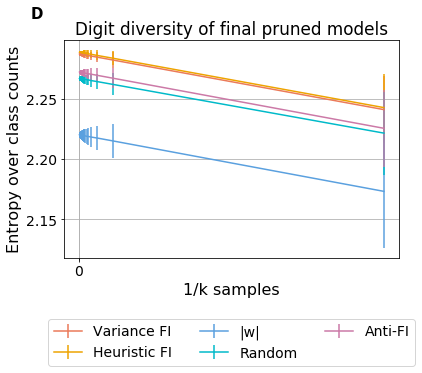

In [90]:
fig = plt.figure(figsize=(6,4))#constrained_layout=True
ax = fig.add_subplot(111)
ax.text(-0.1, 1.1, string.ascii_uppercase[3], transform=ax.transAxes,
                    size=15, weight='bold')
for exp in range(len(my_labels)):
    ax.errorbar(1/frames.astype(float), mean_entropies[exp], yerr=std_entropies[exp], color=exp_colors[exp], label=my_labels[exp])
    ax.set_ylabel('Entropy over class counts', fontsize=fs)
    ax.set_xlabel('1/k samples', fontsize=fs)
    ax.set_xscale('symlog')
ax.set_title('Digit diversity of final pruned models')

ax.grid(True, which='both')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=3)

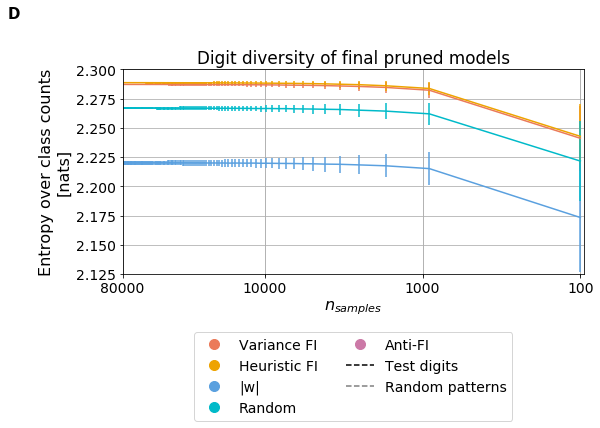

In [91]:
fig = plt.figure(figsize=(8,6))#constrained_layout=True
ax = fig.add_subplot(111)
ax.text(-0.25, 1.25, string.ascii_uppercase[3], transform=ax.transAxes,
                    size=15, weight='bold')
for exp in range(len(my_labels)):
    if my_labels[exp]!='Anti-FI':
        ax.errorbar(frames.astype(float), mean_entropies[exp], yerr=std_entropies[exp], color=exp_colors[exp])
for exp in range(len(exp_names)):
        ax.plot([-5], [-5], marker='o', markersize=10, color=exp_colors[exp], label=my_labels[exp], linestyle='None')
ax.plot([-10, -12], linestyle='--', label='Test digits', color='black')
ax.plot([-10, -12], linestyle='--', label='Random patterns', color='grey')

ax.set_ylabel('Entropy over class counts\n[nats]', fontsize=fs)
ax.set_xlabel(r'$n_{samples}$', fontsize=fs)

ax.set_xscale('symlog')
ax.grid(True, which='both')

ax.set_title('Digit diversity of final pruned models')
ax.invert_xaxis()
ax.set_ylim(2.125,2.3)
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.set_xticks([80000, 10000, 1000, 100])
ax.set_xlim(max_samples,min_samples-5)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=2)
plt.tight_layout()

Legend belongs to figure 4 A and D together. 